## Is there a correlation between Wikipedia page view ranking and edits?

It's not unreasonable to think that articles with more edits tend to be ranked higher in views...

In [80]:
import datetime
import json
from pathlib import Path
import time
import pickle
from pprint import pprint

from mwviews.api import PageviewsClient
import pandas as pd
import requests
import matplotlib.pyplot as plt
from sklearn import preprocessing

In [2]:
%matplotlib inline

In [100]:
def get_table(d, key):
    """Return pandas DataFrame from list of dicts with NaN removed."""
    articles = list(set(row['article'] for day in d for row in d[day]))
    df = pd.DataFrame({'article': articles})
    df = df.set_index('article')
    for day in d:
        day_df = pd.DataFrame()
        day_df['article'] = list(row['article'] for row in d[day])
        day_df[day] = list(row[key] for row in d[day])
        df = df.join(day_df.set_index('article')).dropna()
    print(f'Articles without NaN: {len(df)}')
    return df.dropna()

def get_edits(articles):

    url = 'https://wikimedia.org/api/rest_v1/metrics/edits/per-page/en.wikipedia/{article}/all-editor-types/daily/20190101/20190201'
    headers = {'user-agent': 'Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:47.0) Gecko/20100101 Firefox/47.0'}
    s = requests.Session()
    s.headers.update(headers)
    
    edit_list = []
    failed = set()

    for idx, article in enumerate(articles, 1):
        r = s.get(url.format(article=article))
        try:
            edits = r.json()['items'][0]['results']
        except KeyError:
            print(f'KeyError: {article}')
            failed.add(article)
            continue
        else:
            for edit in edits:
                timestamp = edit.get('timestamp').split('T')[0]
                edit['timestamp'] = datetime.datetime.strptime(timestamp, '%Y-%m-%d')
            edit_list.append({'article': article, 'edits': edits})
            if idx % 25 == 0:  # limited to 25 requests/s
                time.sleep(1)
            if idx % 50 == 0:
                print(f'{idx} completed.')
    print(f'Finished with {len(failed)} errors.')
    return edit_list, failed

### Get top 1000 most viewed articles between 20190101 and 20190201

In [82]:
p = PageviewsClient('cclemon.lian@gmail.com')

In [83]:
daterange = pd.date_range('20190101', '20190131')
daterange

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10', '2019-01-11', '2019-01-12',
               '2019-01-13', '2019-01-14', '2019-01-15', '2019-01-16',
               '2019-01-17', '2019-01-18', '2019-01-19', '2019-01-20',
               '2019-01-21', '2019-01-22', '2019-01-23', '2019-01-24',
               '2019-01-25', '2019-01-26', '2019-01-27', '2019-01-28',
               '2019-01-29', '2019-01-30', '2019-01-31'],
              dtype='datetime64[ns]', freq='D')

In [84]:
top_path = Path('top1000views.pkl')
if top_path.exists():
    print(f'Loading {top_path} from disk...')
    with top_path.open(mode='rb') as f:
        tops = pickle.load(f)
else:
    print("Fetching data...")
    tops = {}
    for date in daterange:
        tops[date] = p.top_articles('en.wikipedia', year=date.year, month=date.month, day=date.day, limit=1000)
    
    with open('top1000views.pkl', 'wb') as f:
        pickle.dump(tops, f)
    print("Done!")

Fetching data...


In [85]:
tops

{Timestamp('2019-01-01 00:00:00', freq='D'): [{'article': 'Main_Page',
   'rank': 1,
   'views': 16865930},
  {'article': 'Special:Search', 'rank': 2, 'views': 1553313},
  {'article': 'Kader_Khan', 'rank': 3, 'views': 491386},
  {'article': 'Bird_Box_(film)', 'rank': 4, 'views': 326112},
  {'article': 'Special:CreateAccount', 'rank': 5, 'views': 301729},
  {'article': 'Jenny_McCarthy', 'rank': 6, 'views': 248022},
  {'article': "New_Year's_Day", 'rank': 7, 'views': 245161},
  {'article': 'Auld_Lang_Syne', 'rank': 8, 'views': 244057},
  {'article': 'Dendrocnide_moroides', 'rank': 9, 'views': 210410},
  {'article': 'Black_Mirror:_Bandersnatch', 'rank': 10, 'views': 187318},
  {'article': 'Bird_Box', 'rank': 11, 'views': 169565},
  {'article': 'Mario_Segale', 'rank': 12, 'views': 144655},
  {'article': 'XHamster', 'rank': 13, 'views': 141474},
  {'article': 'Aquaman_(film)', 'rank': 14, 'views': 139750},
  {'article': 'Donnie_Wahlberg', 'rank': 15, 'views': 137350},
  {'article': 'Christi

In [101]:
rank_df = get_table(tops, 'rank')
rank_df.head()

Articles without NaN: 262


,2019-01-01 00:00:00,2019-01-02 00:00:00,2019-01-03 00:00:00,2019-01-04 00:00:00,2019-01-05 00:00:00,2019-01-06 00:00:00,2019-01-07 00:00:00,2019-01-08 00:00:00,2019-01-09 00:00:00,2019-01-10 00:00:00,...,2019-01-22 00:00:00,2019-01-23 00:00:00,2019-01-24 00:00:00,2019-01-25 00:00:00,2019-01-26 00:00:00,2019-01-27 00:00:00,2019-01-28 00:00:00,2019-01-29 00:00:00,2019-01-30 00:00:00,2019-01-31 00:00:00
article,,,,,,,,,,,,,,,,,,,,,
The_Orville,326.0,306.0,270.0,122.0,303.0,462.0,569.0,607.0,573.0,448.0,...,708.0,874.0,570.0,173.0,364.0,550.0,590.0,734.0,924.0,771.0
Zero_(2018_film),45.0,30.0,36.0,40.0,46.0,61.0,137.0,91.0,82.0,103.0,...,496.0,574.0,608.0,611.0,651.0,798.0,897.0,798.0,900.0,809.0
Stan_Lee,458.0,406.0,464.0,497.0,530.0,579.0,653.0,589.0,506.0,558.0,...,659.0,649.0,793.0,911.0,819.0,334.0,816.0,840.0,812.0,653.0
The_Greatest_Showman,205.0,196.0,256.0,263.0,183.0,305.0,558.0,639.0,582.0,609.0,...,855.0,859.0,737.0,713.0,439.0,419.0,668.0,711.0,824.0,759.0
Ryan_Reynolds,299.0,280.0,293.0,309.0,257.0,348.0,602.0,412.0,402.0,436.0,...,590.0,545.0,420.0,597.0,360.0,517.0,466.0,598.0,428.0,599.0


In [102]:
views_df = get_table(tops, 'views')
views_df.head()

Articles without NaN: 262


,2019-01-01 00:00:00,2019-01-02 00:00:00,2019-01-03 00:00:00,2019-01-04 00:00:00,2019-01-05 00:00:00,2019-01-06 00:00:00,2019-01-07 00:00:00,2019-01-08 00:00:00,2019-01-09 00:00:00,2019-01-10 00:00:00,...,2019-01-22 00:00:00,2019-01-23 00:00:00,2019-01-24 00:00:00,2019-01-25 00:00:00,2019-01-26 00:00:00,2019-01-27 00:00:00,2019-01-28 00:00:00,2019-01-29 00:00:00,2019-01-30 00:00:00,2019-01-31 00:00:00
article,,,,,,,,,,,,,,,,,,,,,
The_Orville,23108.0,20720.0,20258.0,31339.0,20454.0,18224.0,16563.0,13418.0,12746.0,14503.0,...,12454.0,10425.0,13301.0,26491.0,18238.0,16318.0,14558.0,11367.0,9890.0,10760.0
Zero_(2018_film),76794.0,79987.0,69942.0,64054.0,58458.0,53896.0,44871.0,47139.0,38045.0,33050.0,...,15016.0,13200.0,12794.0,12830.0,13136.0,13114.0,11447.0,10760.0,10017.0,10482.0
Stan_Lee,18630.0,17340.0,15051.0,14351.0,14706.0,16316.0,15141.0,13657.0,13501.0,12904.0,...,13017.0,12392.0,11191.0,10254.0,11491.0,21578.0,12075.0,10495.0,10508.0,11848.0
The_Greatest_Showman,31640.0,26562.0,20797.0,19835.0,26633.0,23098.0,16832.0,13083.0,12671.0,12397.0,...,11074.0,10517.0,11608.0,11800.0,16318.0,19135.0,13597.0,11540.0,10437.0,10874.0
Ryan_Reynolds,24203.0,21485.0,19325.0,18307.0,21582.0,21203.0,15944.0,16572.0,15419.0,14751.0,...,13780.0,13566.0,16000.0,12942.0,18427.0,16842.0,17327.0,12874.0,14892.0,12433.0


### Get edits for most viewed articles

In [56]:
edit_path = Path('top1000edits.pkl')

if edit_path.exists():
    print(f'Loading {edit_path} from disk...')
    with edit_path.open('rb') as f:
        edit_list = pickle.load(f)

else:
    articles = views_df.index.values
    edit_list, fails = get_edits(articles)
    
    with open('top1000edits.pkl', 'wb') as f:
        pickle.dump(edit_list, f)

50 completed.
KeyError: Help:IPA/English
100 completed.
150 completed.
200 completed.
250 completed.
Finished with {len(failed)} errors.


In [103]:
len(rank_df.index.values)

262

In [104]:
edit_list[:10]

[{'article': 'The_Orville',
  'edits': [{'edits': 3, 'timestamp': datetime.datetime(2019, 1, 1, 0, 0)},
   {'edits': 4, 'timestamp': datetime.datetime(2019, 1, 2, 0, 0)},
   {'edits': 6, 'timestamp': datetime.datetime(2019, 1, 3, 0, 0)},
   {'edits': 13, 'timestamp': datetime.datetime(2019, 1, 4, 0, 0)},
   {'edits': 6, 'timestamp': datetime.datetime(2019, 1, 5, 0, 0)},
   {'edits': 3, 'timestamp': datetime.datetime(2019, 1, 6, 0, 0)},
   {'edits': 8, 'timestamp': datetime.datetime(2019, 1, 7, 0, 0)},
   {'edits': 0, 'timestamp': datetime.datetime(2019, 1, 8, 0, 0)},
   {'edits': 7, 'timestamp': datetime.datetime(2019, 1, 9, 0, 0)},
   {'edits': 4, 'timestamp': datetime.datetime(2019, 1, 10, 0, 0)},
   {'edits': 17, 'timestamp': datetime.datetime(2019, 1, 11, 0, 0)},
   {'edits': 5, 'timestamp': datetime.datetime(2019, 1, 12, 0, 0)},
   {'edits': 7, 'timestamp': datetime.datetime(2019, 1, 13, 0, 0)},
   {'edits': 3, 'timestamp': datetime.datetime(2019, 1, 14, 0, 0)},
   {'edits': 3, 't

In [109]:
dfs = []
for edit in edit_list:
    dfs.append(pd.DataFrame({e['timestamp']: e['edits'] for e in edit['edits']}, index=[edit['article']]))
edit_df = pd.concat(dfs).dropna()
edit_df.head()

,2019-01-01 00:00:00,2019-01-02 00:00:00,2019-01-03 00:00:00,2019-01-04 00:00:00,2019-01-05 00:00:00,2019-01-06 00:00:00,2019-01-07 00:00:00,2019-01-08 00:00:00,2019-01-09 00:00:00,2019-01-10 00:00:00,...,2019-01-22 00:00:00,2019-01-23 00:00:00,2019-01-24 00:00:00,2019-01-25 00:00:00,2019-01-26 00:00:00,2019-01-27 00:00:00,2019-01-28 00:00:00,2019-01-29 00:00:00,2019-01-30 00:00:00,2019-01-31 00:00:00
The_Orville,3,4,6,13,6,3,8,0,7,4,...,4,1,3,23,7,9,25,12,1,8
Zero_(2018_film),6,2,3,0,2,2,0,0,2,16,...,0,0,0,0,3,0,1,0,0,0
Stan_Lee,0,0,0,3,0,0,0,0,1,1,...,0,0,0,0,1,0,0,0,0,5
The_Greatest_Showman,0,4,4,4,1,0,1,1,2,0,...,0,0,0,1,0,0,2,2,0,0
Ryan_Reynolds,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0


In [105]:
# Articles with the most change in rank
rank_diff_series = rank_df.apply(lambda row: row.max() - row.min(), axis=1).sort_values(ascending=False)
rank_diff_series

article
List_of_Super_Bowl_champions                   945.0
Super_Bowl_LIII                                933.0
Mac_Miller                                     929.0
Mahershala_Ali                                 926.0
Jeffrey_Dahmer                                 919.0
Richard_Madden                                 917.0
Black_Mirror                                   899.0
Sam_Elliott                                    897.0
The_Upside                                     882.0
Alfred_the_Great                               877.0
Drake_(musician)                               876.0
Zero_(2018_film)                               870.0
Marie_Kondo                                    870.0
The_Orville                                    864.0
Escape_Room_(film)                             841.0
Sara_Ali_Khan                                  831.0
Billie_Eilish                                  827.0
James_McAvoy                                   827.0
Virat_Kohli                           

### Correlation between rank and edits???

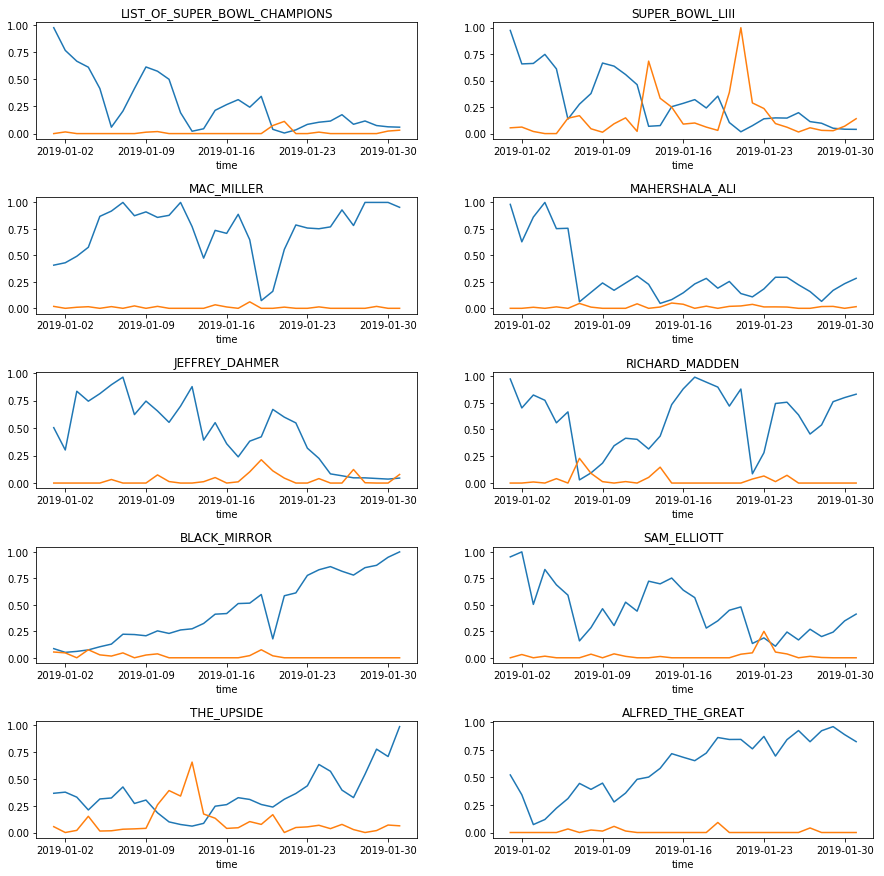

In [117]:
# Normalize to between 0 and 1. Is this even right???
min_max_scaler = preprocessing.MinMaxScaler()
rank_scaled = pd.DataFrame(min_max_scaler.fit_transform(rank_df), index=rank_df.index, columns=rank_df.columns)
edit_scaled = pd.DataFrame(min_max_scaler.fit_transform(edit_df), index=edit_df.index, columns=edit_df.columns)

fig, axes = plt.subplots(5, 2, figsize=(15, 15))
fig.subplots_adjust(hspace=0.5)
for ax, article in zip(axes.flatten(), rank_diff_series.index[:10]):
    rank = rank_scaled.loc[article]
    edits = edit_scaled.loc[article]
    ax.plot(rank)
    ax.plot(edits)
    ax.set(title=article.upper(), xlabel='time')

### Is there correlation between rank and edits? Not really?

In [113]:
# Calculate correlation between ranks and edits
rank_df.corrwith(edit_df, axis=1).dropna().sort_values(ascending=False).mean()

-0.11136675578571238